In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import deepdish as dd
import scipy.stats as stats
from matplotlib.pyplot import cm 
import os

%matplotlib inline

In [2]:
def plot_histogram(filename, index, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    experiment = dd.io.load(filename)

    color = ['r', 'g', 'b', 'c', 'k']
    
    x_min = []
    x_max = []
    y_max = []
    
    for i in range(len(experiment[index])):

        k = index

        noise = np.array(experiment[k][i]).reshape(-1, 1)
        mu = np.mean(noise)
        noise_norm = noise - mu
        mu_norm = np.mean(noise_norm)
        sigma_norm = np.std(noise_norm)

        X = np.linspace(mu_norm-3*sigma_norm, mu_norm+ 3*sigma_norm, 1000)
        Y = stats.norm.pdf(X, mu_norm, sigma_norm)
        ax.plot(X, Y, color=color[i], linestyle='-', label = 'Layer '+str(i+1))
        x_min.append(np.min(X))
        x_max.append(np.max(X))
        y_max.append(np.max(Y))
        
    
    ax.set_ylim(ymin=0, ymax=int(np.max(y_max))+1)
    
    name = 'histogram/'
    
    if 'activation' in filename:
        ax.set_xlabel('Activation value')
        ax.set_xlim([-1, 1])
        name += '-'.join(filename.split('-')[1:4]) + '-hist-activation'
    else:
        ax.set_xlabel('Backpropogated gradients')
        ax.set_xlim(xmax = np.max(x_max), xmin=np.min(x_min))
        name += '-'.join(filename.split('-')[1:4]) + '-hist-gradients'
    
    if index == 0:
        name += '-initial.png'
    else:
        name += '-final.png'
    
    #plt.legend()
    
    #plt.savefig(name)
    #print (y_max)
    
    return ax

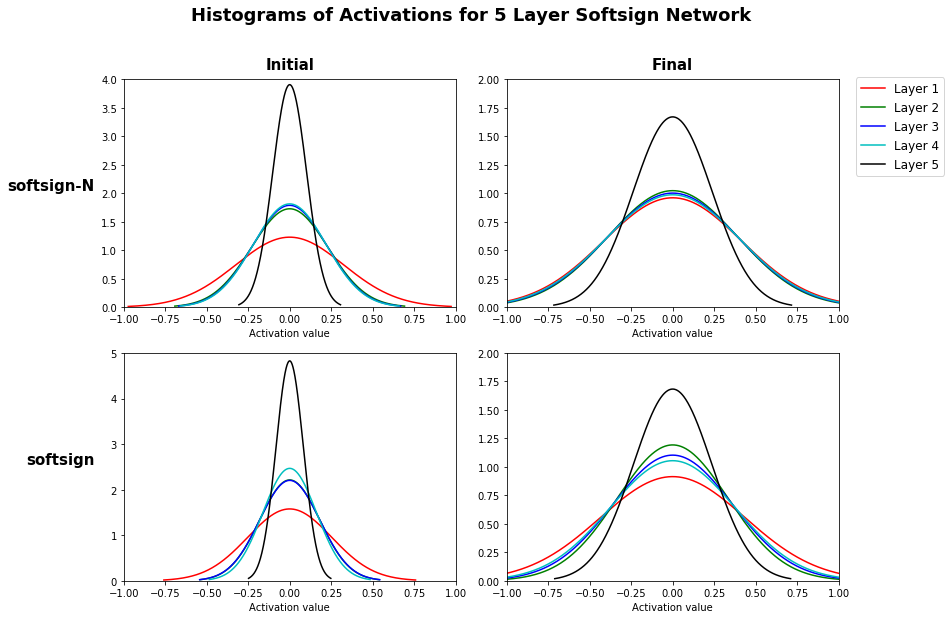

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

counter = 0

for i in ['softsign']:
    
    for N in ['N', 'notN']:
        
        for l in [1]:
            
            for f in ['activations']:
                
                for p in [0, -1]:

                    filename = 'logs/shapeset-' + i + '-' + N + '-' + str(l) + '-history-' + f + '.h5'

                    fname = os.path.join(os.path.dirname(os.getcwd()), filename)

                    L = plot_histogram(filename=fname, index=p, ax=axes.flat[counter])
                    
                    if counter==0:
                        L.set_title('Initial', fontsize=15, weight='bold', pad=10)
                        L.set_ylabel(i + '-' + N, fontsize=15, weight='bold', rotation=0, labelpad=50)
                        
                    
                    if counter==1:
                        L.set_title('Final', fontsize=15, weight='bold', pad=10)                        
                        
                    
                    if counter==2:
                        
                        L.set_ylabel(i, fontsize=15, weight='bold', rotation=0, labelpad=50)
                    
                    counter += 1
                    
fig.legend(*L.get_legend_handles_labels(), loc='upper right', bbox_to_anchor=(1.1,0.951), fontsize=12);
fig.tight_layout()
fig.suptitle('Histograms of Activations for 5 Layer Softsign Network', fontsize=18, weight='bold', y=1.07, x=0.55);
#fig.suptitle('Histograms of Gradients for 4 Layer Sigmoid Network', fontsize=18, weight='bold', y=1.07, x=0.55);

fig.savefig('histogram/softsign.png', bbox_inches='tight', format='png')
#fig.savefig('histogram/sigmoid4layer_grads.png', bbox_inches='tight', format='png')

In [27]:
def plot_marker(filename, marker_type='std', percentile=None, join=False, ax=None):
    
    '''
        marker_type : {'std', 'percentile'}
        
        percentile : int value between 0 and 100. Only used if marker_type is 'percentile'
        
        join: True or False, for individual or merged plots
    '''
    
    experiment = dd.io.load(filename)

    color = ['r', 'g', 'b', 'c', 'k']
    mark = ['>', 'o', 'x', '+', 's']
       
    epochs = len(experiment)
    layers = len(experiment[0])
    
    if join:
        markers = np.empty(shape=(epochs, layers, 2))
    else: 
        markers = np.empty(shape=(epochs, layers, 1))
    
    for e in range(epochs):
        
        for l in range(layers):
            
            values = np.array(experiment[e][l]).reshape(-1, 1)
            
            if join:
                markers[e, l, 0] = np.std(values)
                markers[e, l, 1] = np.percentile(values, percentile)
            else:
                if marker_type == 'std':
                    markers[e, l] = np.std(values)
                
                elif marker_type == 'percentile':
                    markers[e, l] = np.percentile(values, percentile)
                
                else:
                    assert ValueError('Wrong!')
            
    for l in range(layers):
        
        ax.plot(range(epochs), markers[:, l, 0], color=color[l], label='Layer '+str(l+1), marker=mark[l], linewidth=1, markersize=8, markerfacecolor='none', markevery=5)
        ax.plot(range(epochs), -markers[:, l, 0], color=color[l], marker=mark[l], linewidth=1, markersize=8, markerfacecolor='none', markevery=5)
    
        if join:
            every = range(0, 125, 5) 
            ax.scatter(every, markers[every, l, 1], facecolors='none', edgecolors=color[l], marker=mark[l])
            ax.scatter(every, -markers[every, l, 1], facecolors='none', edgecolors=color[l], marker=mark[l])
    
    
    #ax.legend(loc='upper left', bbox_to_anchor=(1,0.7))
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=-1, ymax=1)
    ax.grid()
    ax.set_xlabel('Epochs of 20k mini-batch updates', fontsize=12)
    
    if 'activation' in filename:
        ax.set_ylabel('Activation Value')
        name = '-'.join(filename.split('-')[1:4]) + '-activation'
    else:
        ax.set_ylabel('Backpropogated Gradients')
        name = '-'.join(filename.split('-')[1:4]) + '-gradients'
        
    if join:
        name += 'join.png'
    else:
        name += marker_type + '.png'
    
    #plt.savefig(name, bbox_inches='tight')
    return ax
    

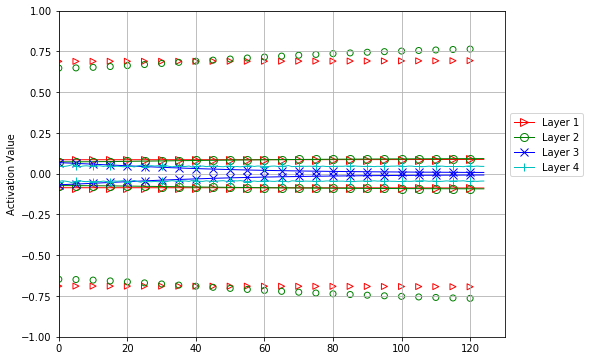

In [9]:
filename = '../logs/shapeset-sigmoid-notN-0-history-activations.h5'
plot_marker(filename, marker_type='std', percentile=98, join=True)

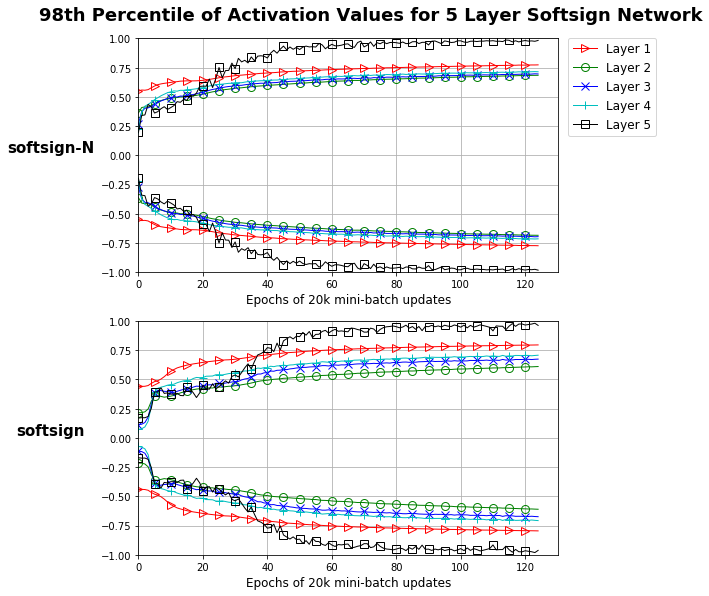

In [46]:
import os


fig, axes = plt.subplots(2, 1, figsize=(8, 8))

counter = 0

for i in ['softsign']:
    
    for N in ['N', 'notN']:
        
        for l in [1]:
            
            for f in ['activations']:
                
                filename = 'logs/shapeset-' + i + '-' + N + '-' + str(l) + '-history-' + f + '.h5'

                fname = os.path.join(os.path.dirname(os.getcwd()), filename)

                L = plot_marker(fname, marker_type='percentile', percentile=98, join=False, ax=axes.flat[counter])
                #L = plot_marker(fname, marker_type='std', percentile=None, join=False, ax=axes.flat[counter])
                    
                if counter==0:
                    #L.set_title('Initial', fontsize=15, weight='bold', pad=10)
                    L.set_ylabel(i + '-' + N, fontsize=15, weight='bold', rotation=0, labelpad=50)
                        
                    
                if counter==1:
                    #L.set_title('Final', fontsize=15, weight='bold', pad=10)    
                    L.set_ylabel(i, fontsize=15, weight='bold', rotation=0, labelpad=50)
                        
                    
                if counter==2:
                        
                    L.set_ylabel(i, fontsize=15, weight='bold', rotation=0, labelpad=50)
                    
                counter += 1
                    
fig.legend(*L.get_legend_handles_labels(), loc='upper right', bbox_to_anchor=(1.15,0.98), fontsize=12);
fig.tight_layout()
#fig.suptitle('98th Percentile of Activation Values for 5 Layer Tanh Network on Shapeset-3x2', fontsize=18, weight='bold', y=1.03,x=0.65);
fig.suptitle('98th Percentile of Activation Values for 5 Layer Softsign Network', fontsize=18, weight='bold', y=1.03,x=0.65);

fig.savefig('percentile/softsign.png', bbox_inches='tight', format='png')